In [1]:
# 필요한 라이브러리 Import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
from scipy.stats import norm #

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import gc

In [2]:
# 데이터 경로 지정하기
dir_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = os.path.join(dir_path, 'train.csv')
sub_data_path = join(dir_path, 'test.csv')
print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
# 데이터 불러오기 
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(df_train.shape))

# test 셋에는 우리가 맞춰야할 집가격 price 가 없어 컬럼이 1개 적다.
print('test data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
df_train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


## 2. 데이터 EDA 


### 변수 시각화 (목적변수)

In [5]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

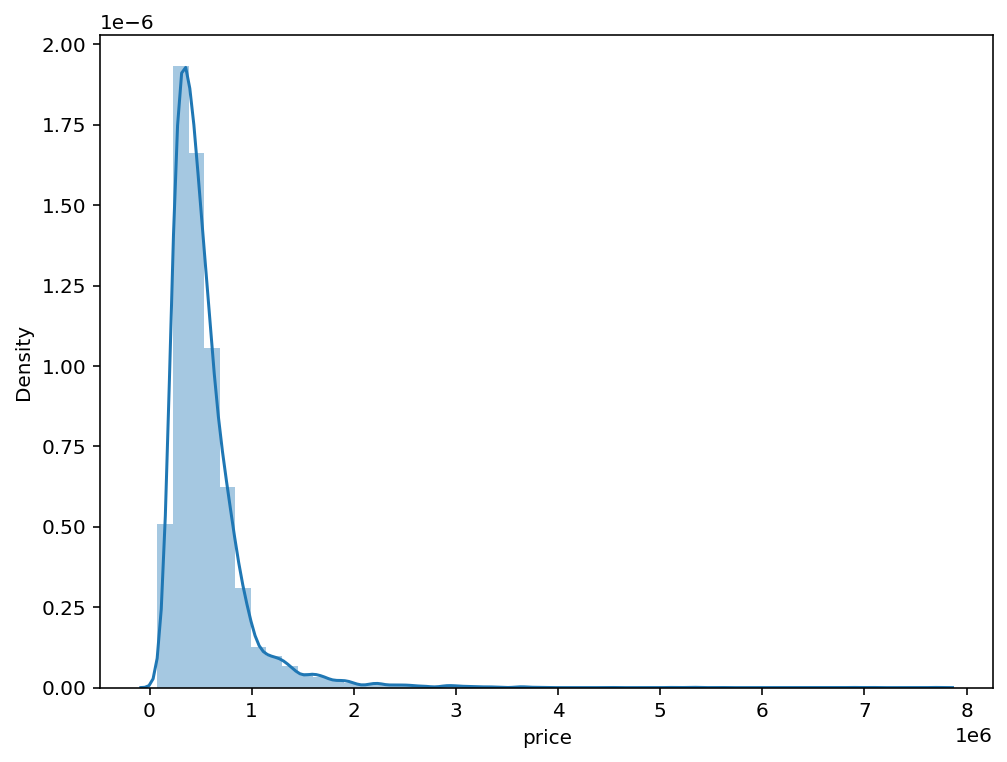

In [6]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [7]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price'].skew())
print("Kurtosis: %f" % df_train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


- 왜도 : 오른쪽 꼬리가 길수록 값이 더 큽니다. 
- 첨도 (kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, scatter은 정규 분포에 가깝습니다. (K <3), 분포가 정규 분포보다 더 평탄하게 평탄하다고 판단 할 수 있으며, 첨도가 3보다 큰 양수인 경우 (K> 3), 분포가보다 뾰족한 분포로 간주 할 수 있습니다.

회귀모델을 사용할것이기 때문에 Normalize로 price분포 정규분포로 만들어주자!

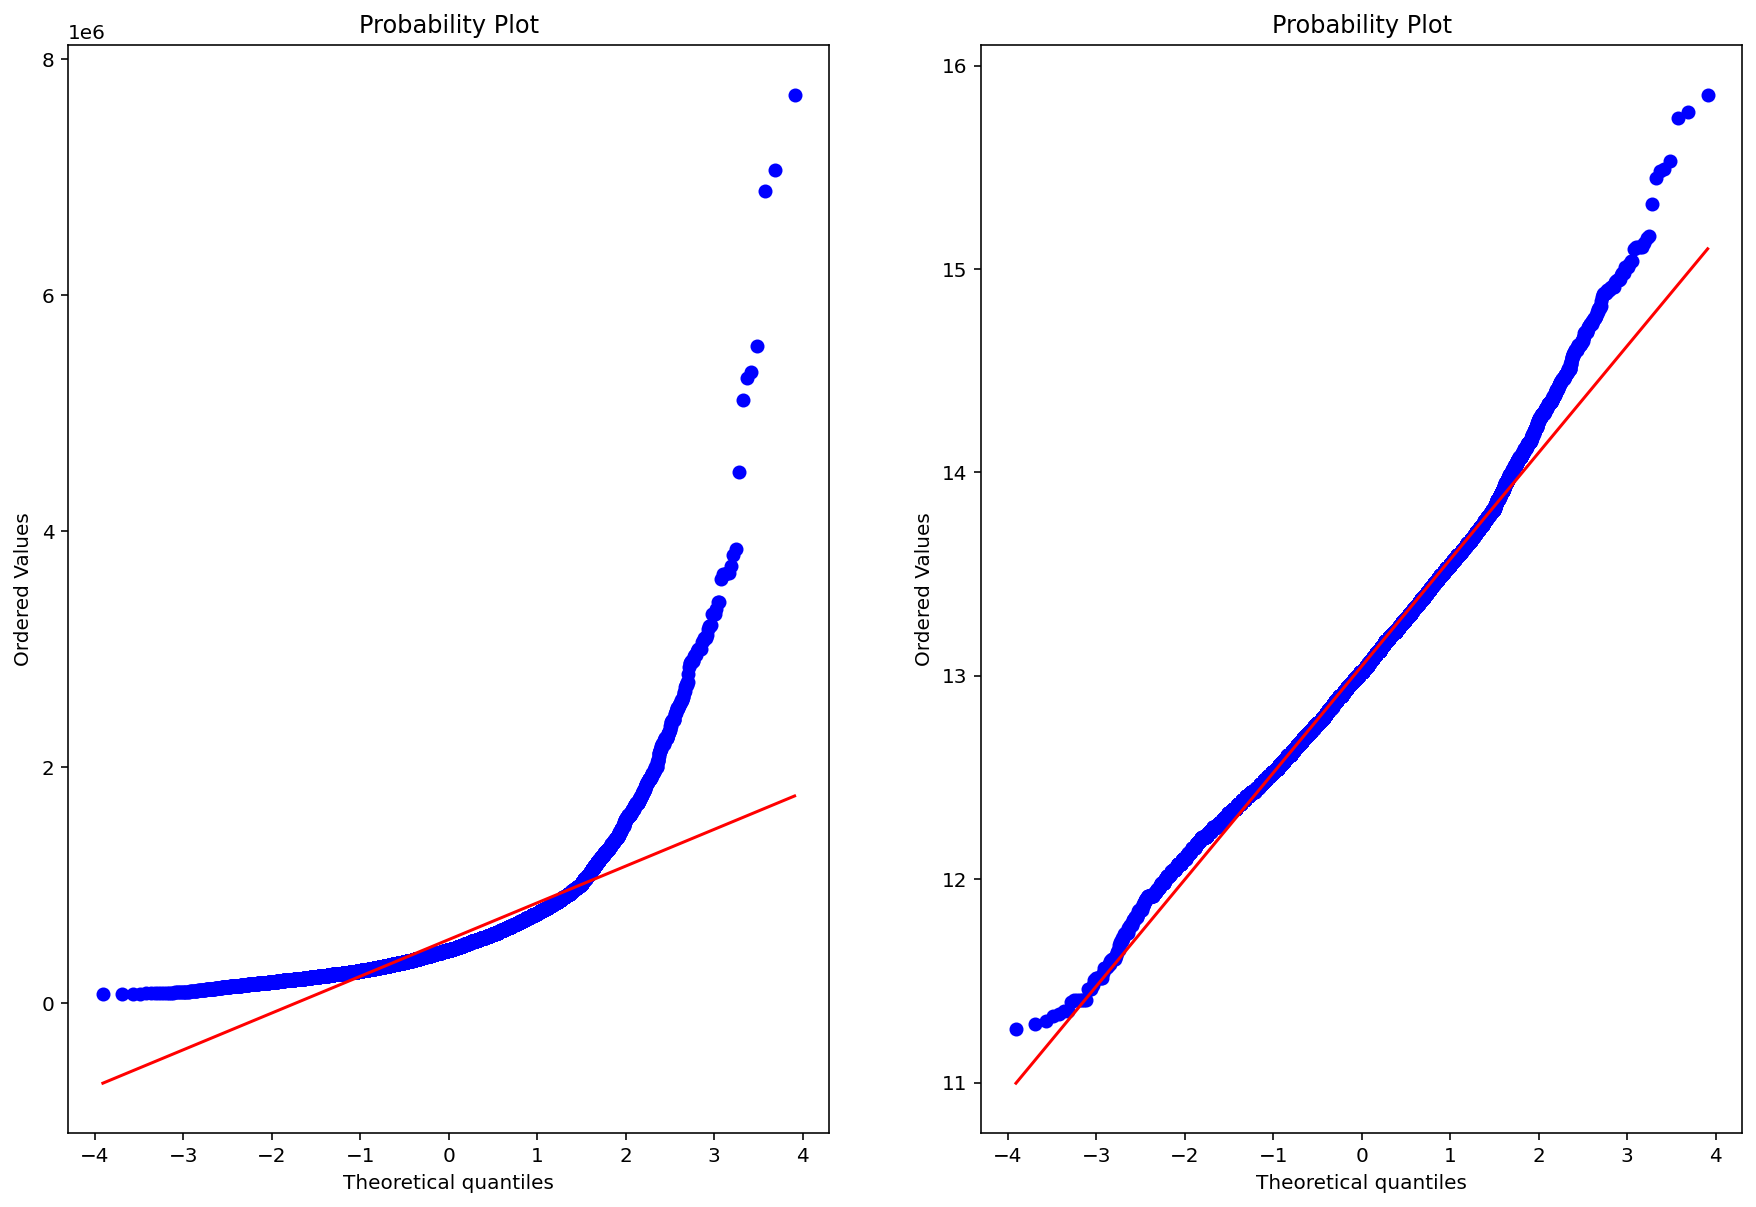

In [8]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

로그 변환하면 정규성 가지는 거 확인 가능

<AxesSubplot:xlabel='price', ylabel='Density'>

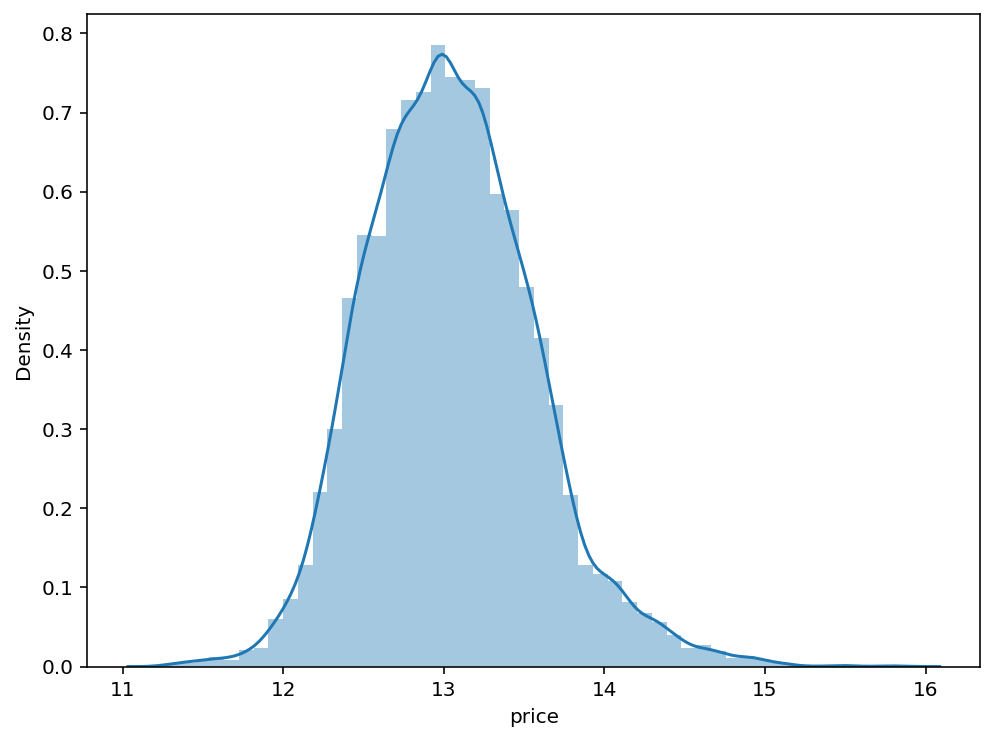

In [9]:
df_train['price'] = np.log1p(df_train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])


## 상관관계를 확인해본다면? (반응변수)
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

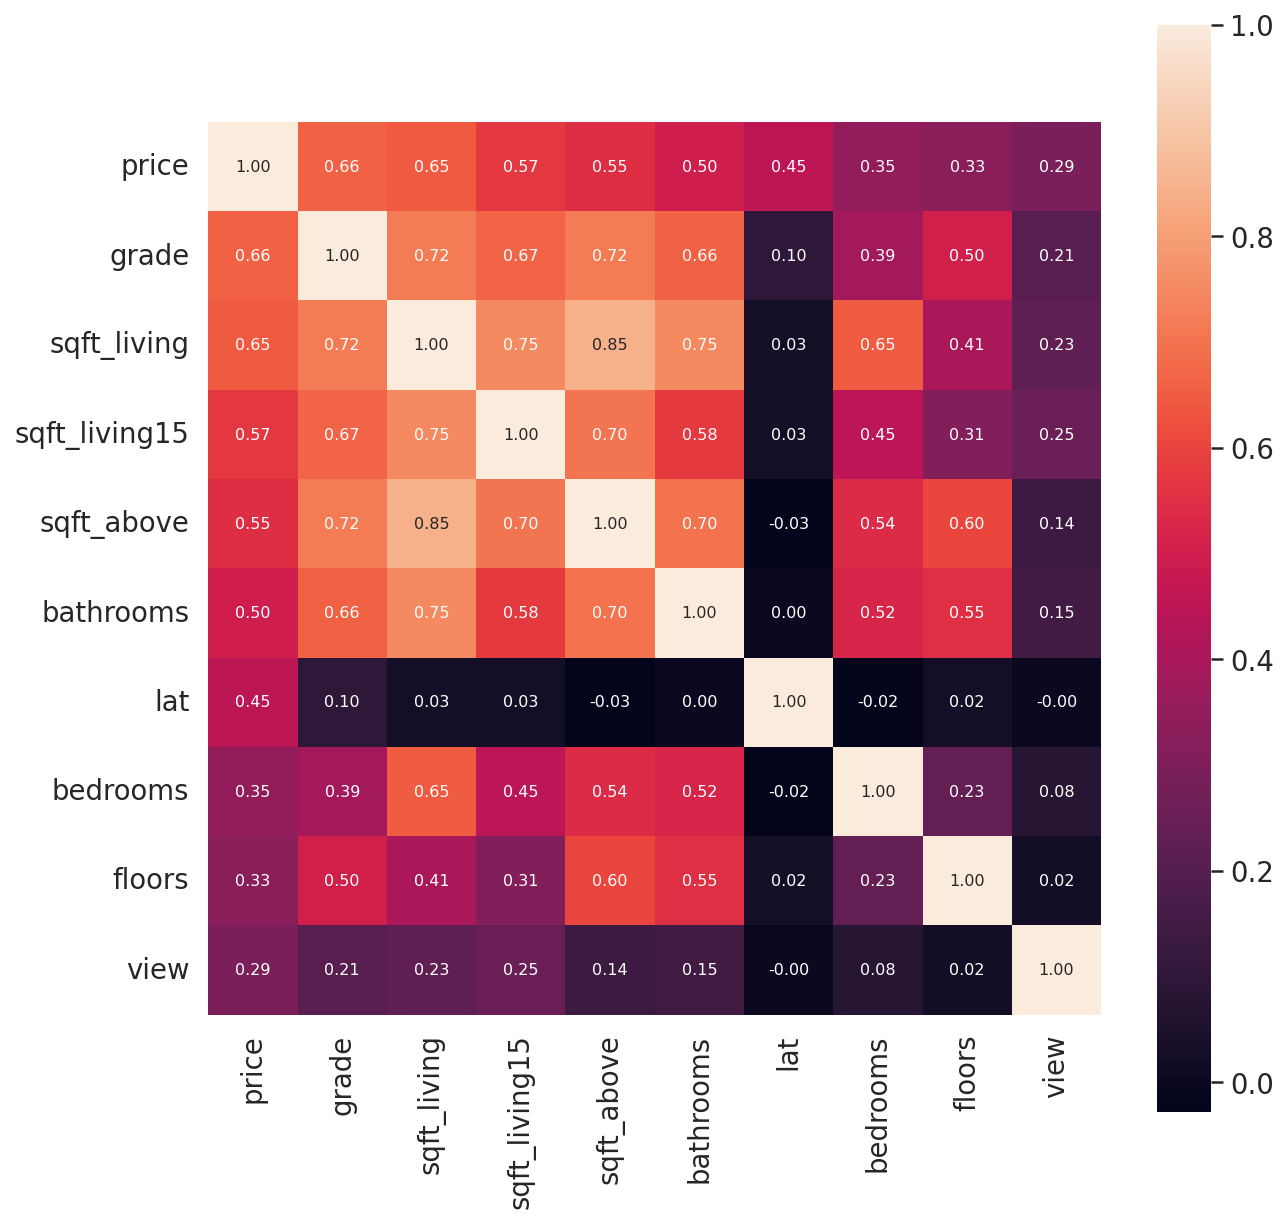

In [10]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

여기서 Price와 가장 상관관계가 높은 변수 9개를 순서대로 나열하자면
- 1. **grade** - King County grading 시스템 기준으로 매긴 집의 등급
- 2. **sqft_living** - 주거 공간의 평방 피트
- 3. **sqft_living15** - 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- 4. sqft_above - 지하실을 제외한 평방 피트
- 5. bathrooms : 침실당 화장실 개수
- 6. lat : 위도
- 7. bedrooms : 침실의 수
- 8. floors : 집의 층 수
- 9. view : 집이 얼마나 좋아 보이는지의 정도

-> **위도가 흥미롭게도 상관관계가 0.45로 높은 편인데 위도가 증가함에 따라 왜 가격이 증가하는가?**
- 데이터에 해당하는 지역이 시애틀이고, 북쪽으로 갈수록 지역이 잘 정리되고 살기 좋은 집들이 많아 그런 것으로 Discussion에서 인사이트 얻음 <br>
[참고] https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83549

-> 상관관계가 0.1보다 작은 id보다 낮은 **sqft_lot, long, sqft_lot15,id, condition,zipcode** 어떻게 처리하면 좋을지 고민해보자

### grade 변수 시각화
- price와 가장 상관관계가 높은 grade 변수의 boxplot 그려보기
- grade의 경우 1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있다고 한다.

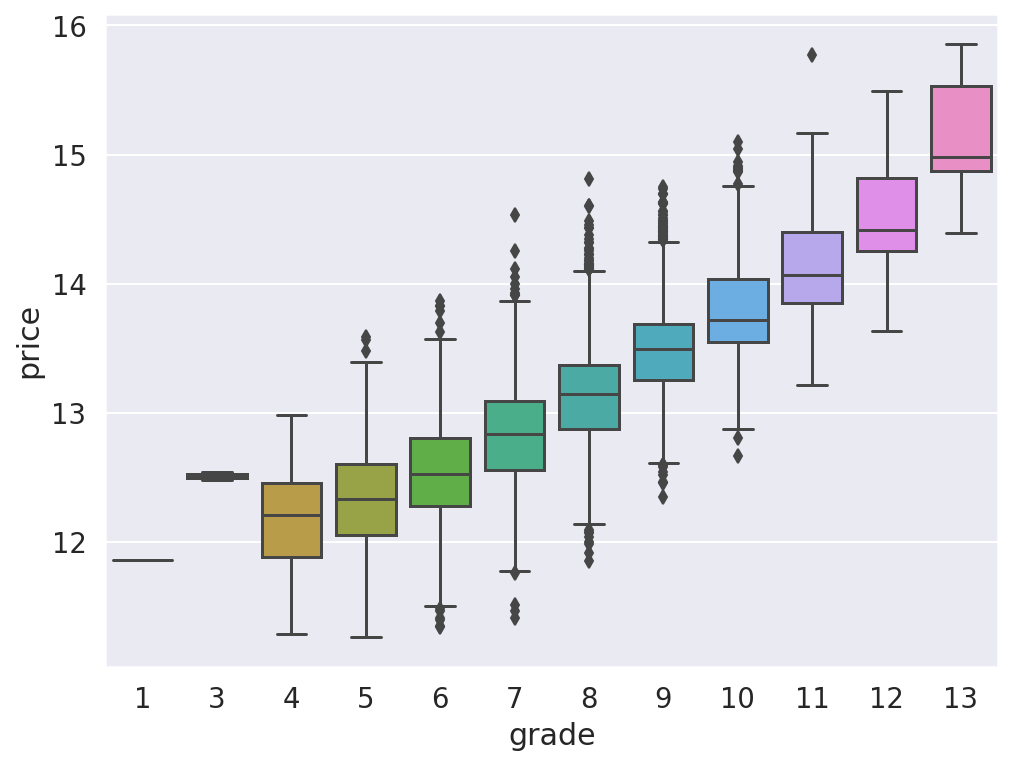

In [11]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

### [ 살펴볼 점 3가지 ]
- **등급 3의 경우 값이 큰 이유**
- **등급 7,8,9에서 이상치가 많은 이유**
- **등급 8과 11에서 차이가 큰 이상치가 나타나는 이유**

### sqft_living 변수 시각화
sqft_living = 실제 사용 면적 / sqft_lot

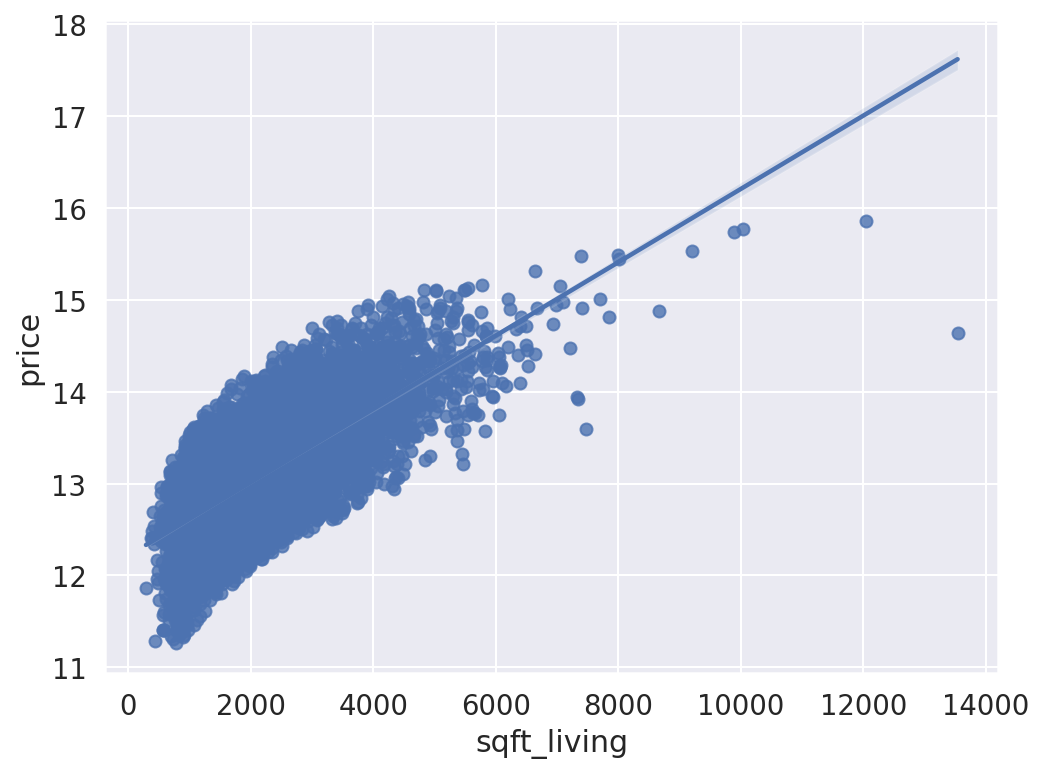

In [12]:
data = pd.concat([df_train['price'],df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

### sqft_living15 변수 시각화
sqft_living15 :  2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

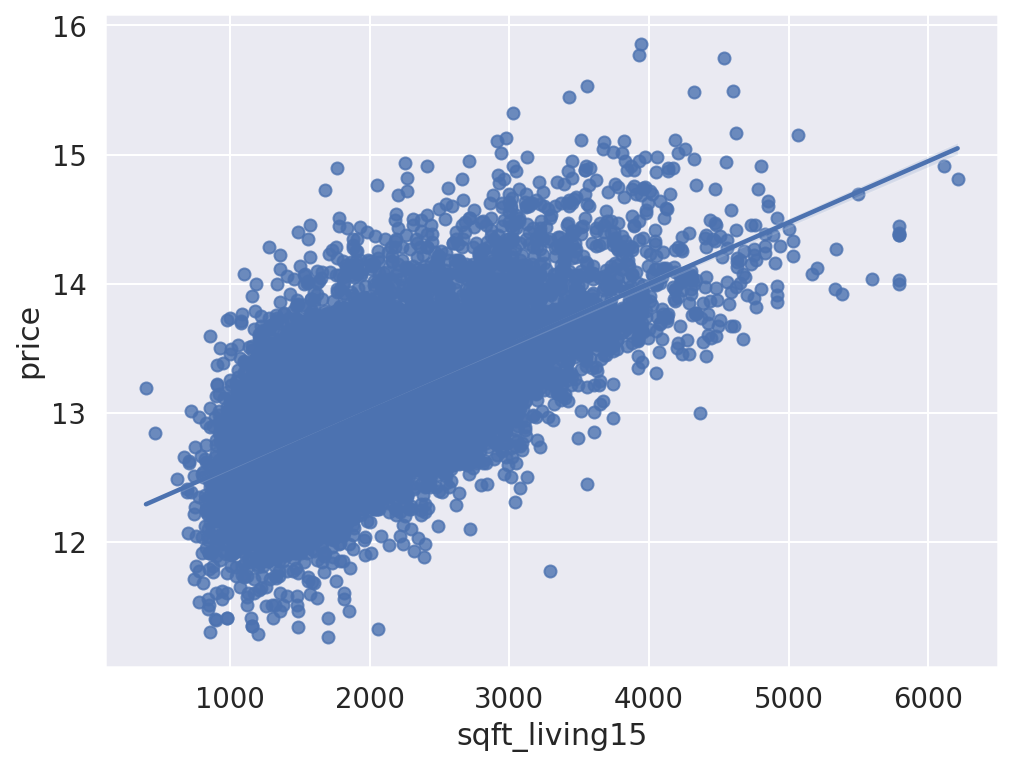

In [13]:
data = pd.concat([df_train['price'],df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

-> sqft_living 보다 sqft_living15의 가격 분산이 더 크다. <br>
2015년 기준이고 재건축 영향을 받아 그런걸로 예상됨

### sqft_above 변수 시각화
sqft_above - 지하실을 제외한 평방 피트

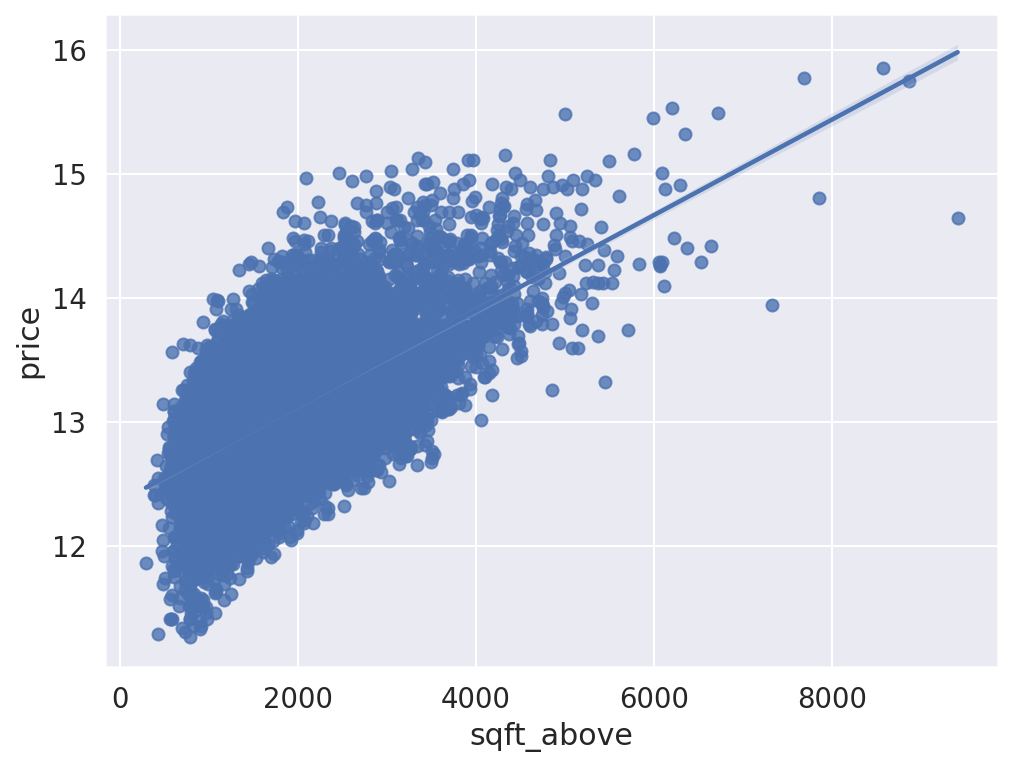

In [14]:
data = pd.concat([df_train['price'],df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

### bathrooms, bedrooms 변수 시각화

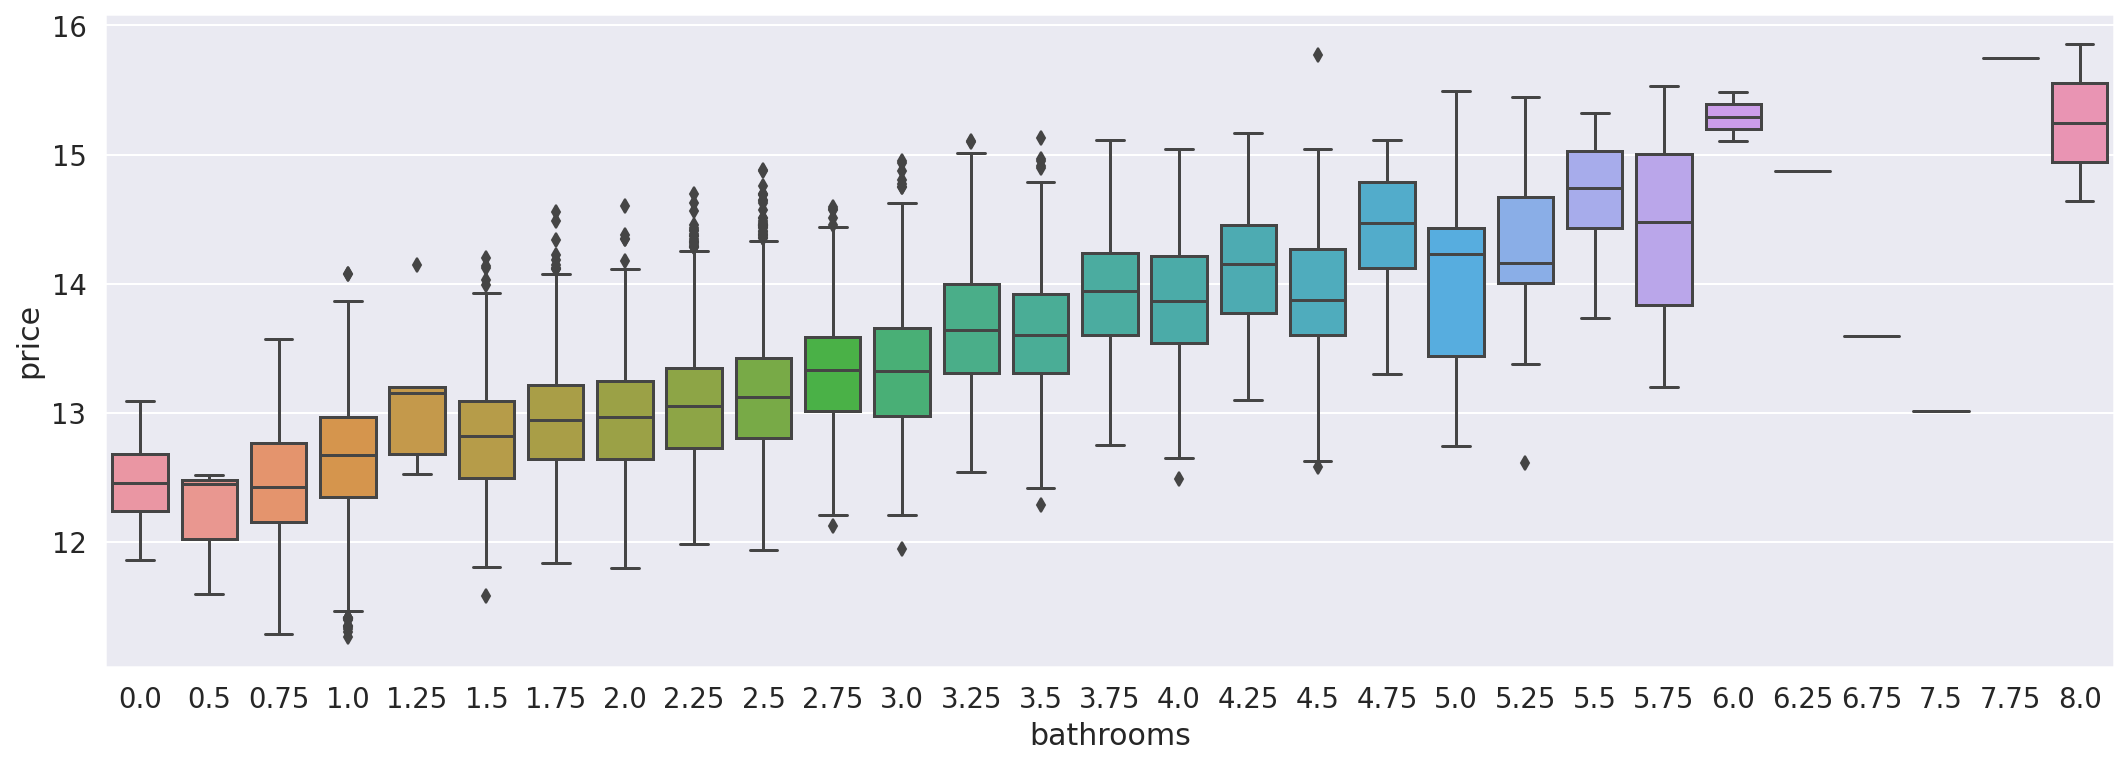

In [15]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

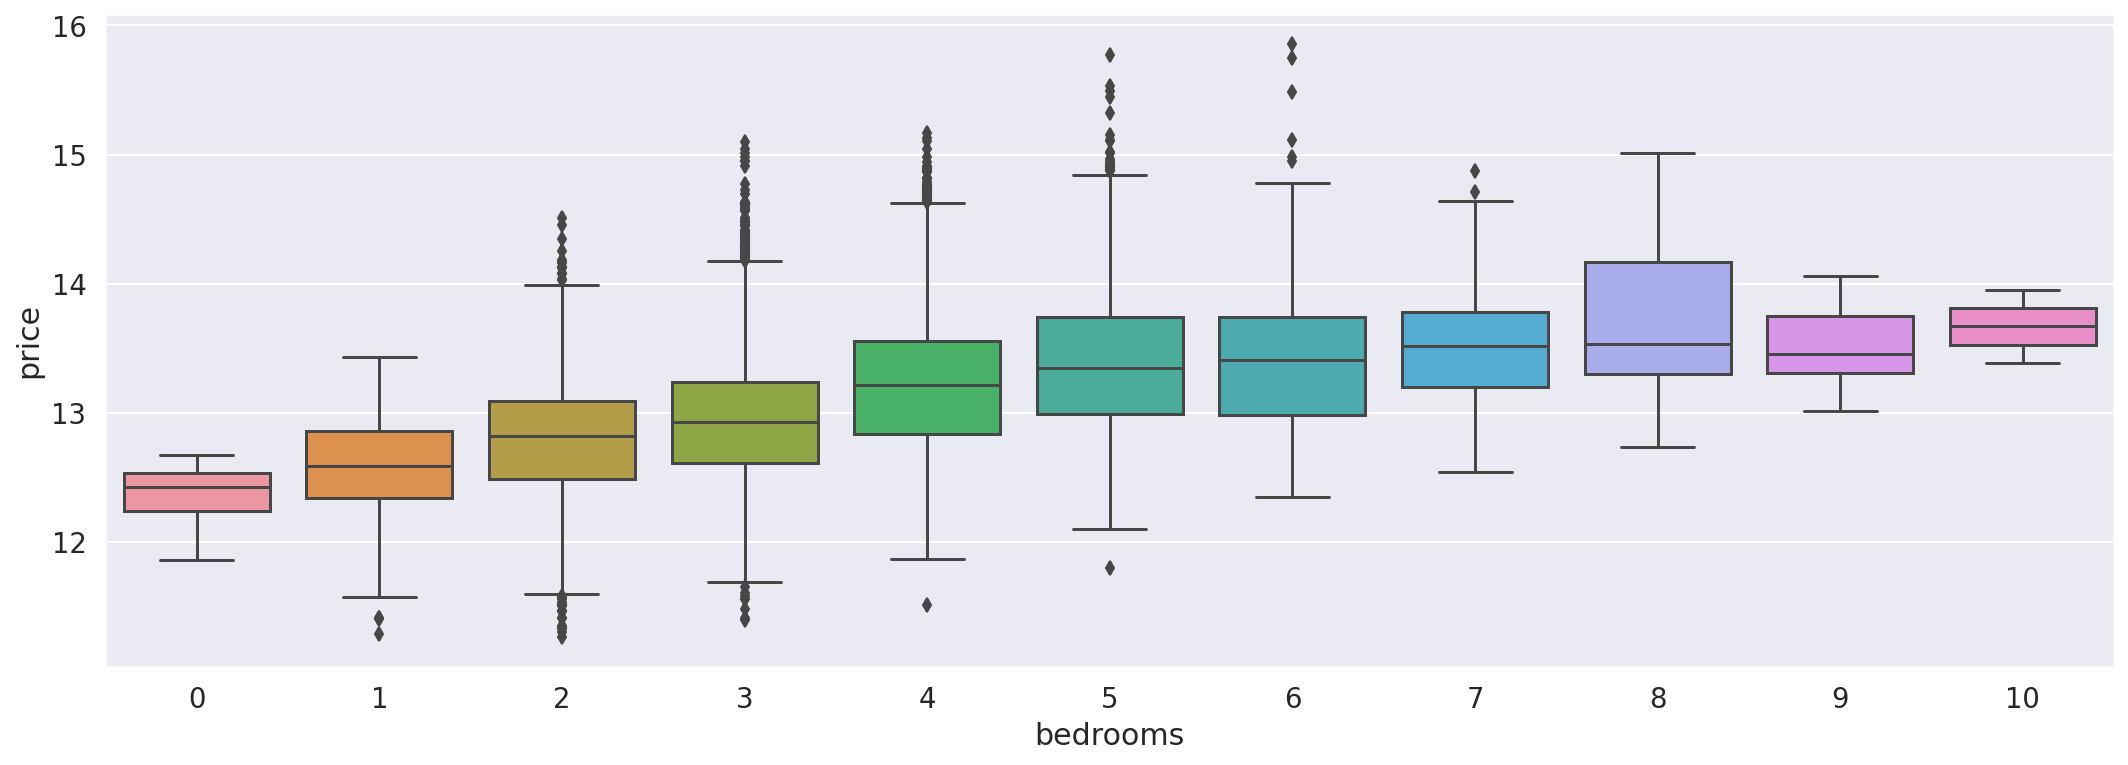

In [16]:
data = pd.concat([df_train['price'],df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

**2~6의 경우 방이 갯수가 작아서 가격이 높은 집들이 있는거 확인 가능.**

### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

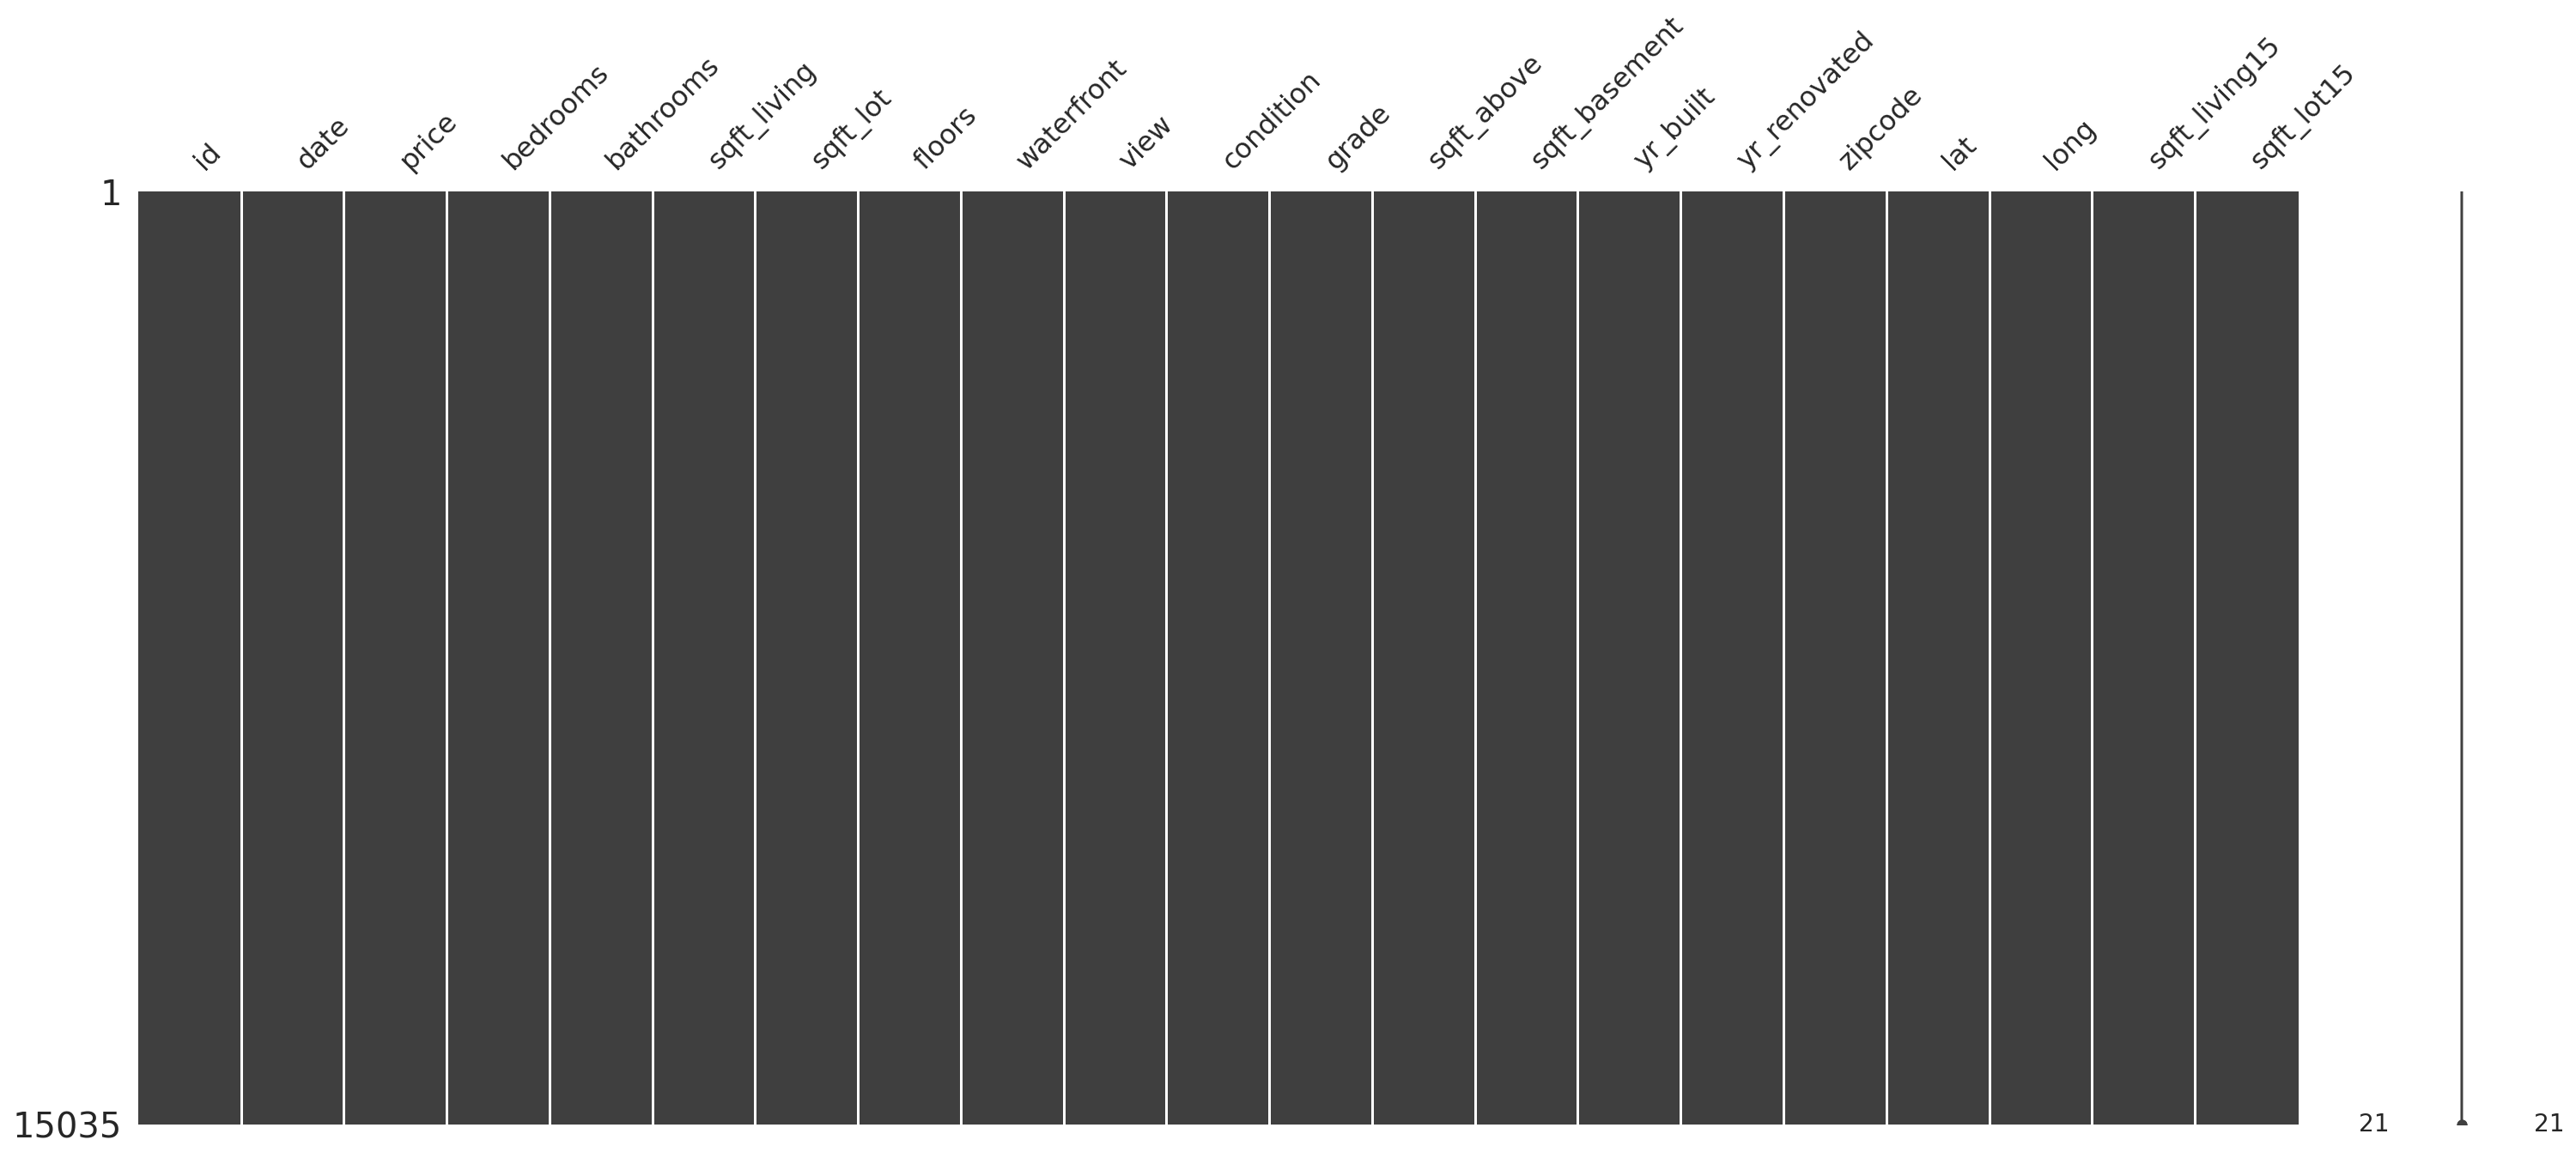

In [17]:
msno.matrix(df_train)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

id로 데이터프레임 인덱싱 적용 사용법을 먼저 익혀봅시다.

In [18]:
# 1. id 컬럼에 결측치 있는 지 확인
null_check = pd.isnull(df_train['id'])
print(null_check)

0        False
1        False
2        False
3        False
4        False
         ...  
15030    False
15031    False
15032    False
15033    False
15034    False
Name: id, Length: 15035, dtype: bool


In [19]:
# 2. 인덱싱으로 결측치인 데이터 뽑아내기
null_data = df_train.loc[null_check,'id']
null_data
# 인덱싱 이용하면 df 그대로 사용 가능

Series([], Name: id, dtype: int64)

In [20]:
# 3. 결측 데이터 갯수 세기
print('{} : {}'.format('id',len(null_data.values)))

id : 0


In [21]:
# 1,2,3 한번에 작성하면
print('{} : {}'.format('id',len(df_train.loc[pd.isnull(df_train['id']),'id'].values)))

id : 0


In [22]:
# 모든 컬럼에 적용해서 결측치 갯수 세기
for c in df_train.columns:
    print('{} : {}'.format(c, len(df_train.loc[pd.isnull(df_train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 유니크한 갯수 계산

In [23]:
!pip install plotly

In [24]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import time
import random

def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
    return color


train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            color= generate_color(),
            #width= 2,
        ), opacity = 0.45
    )
    ),
    ]
layout= go.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='skin')

In [25]:
df_train['floors'].unique() # 소숫점 - 다락방 끼고 있는 형태

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

## 3. 데이터 전처리

### 이상치 제거
- sqft_living, grade, bedrooms

#### sqft_living

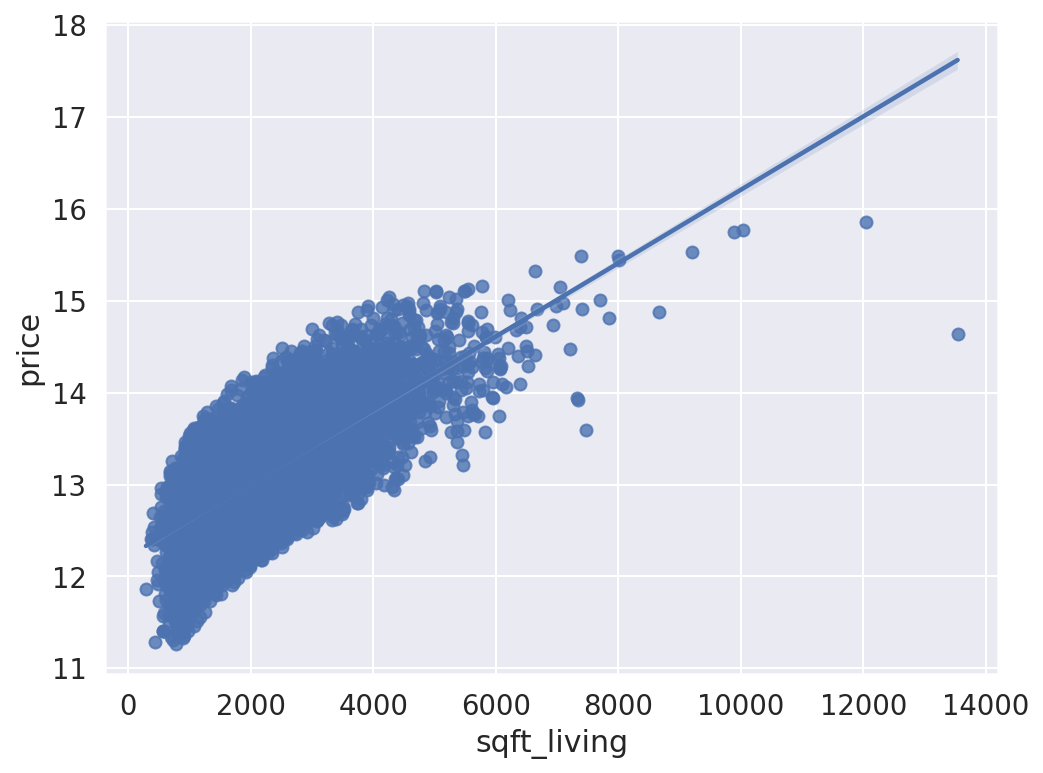

In [26]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [27]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [28]:
# 위 이상치는 다른 변수들을 봐도 큰 의미 없으므로 제거하자
df_train = df_train.loc[df_train['id']!=8912]

#### grade

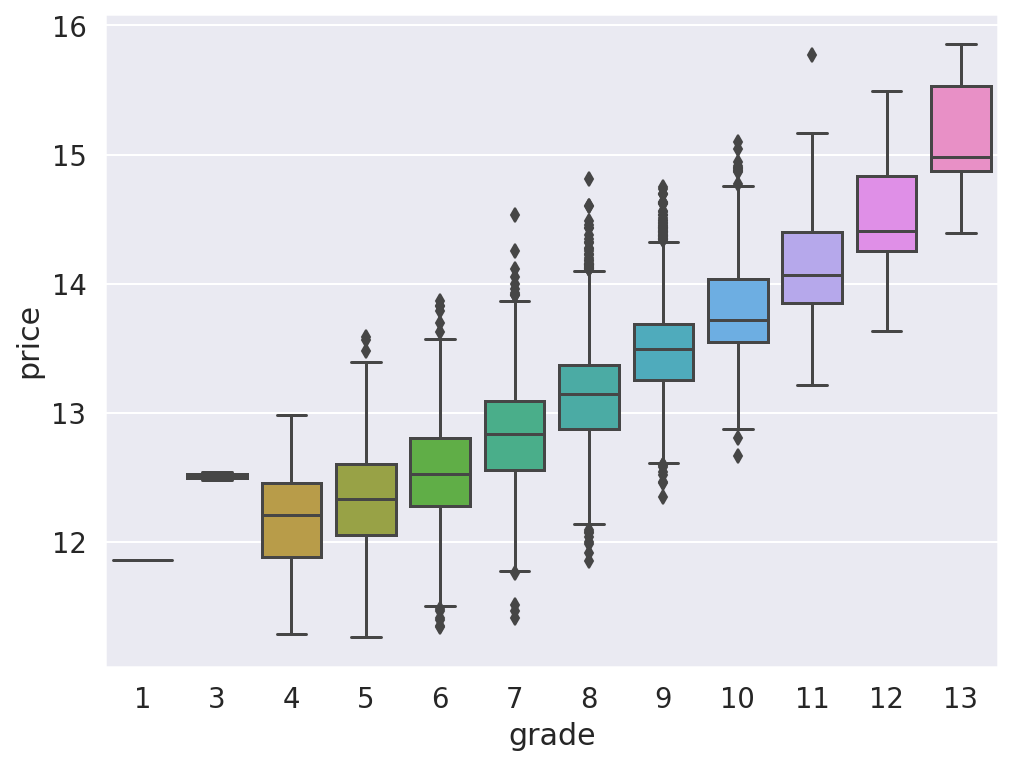

In [29]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [30]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [31]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [32]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위의 3값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거

In [33]:
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7173]
df_train = df_train.loc[df_train['id']!=2775]

### bedrooms

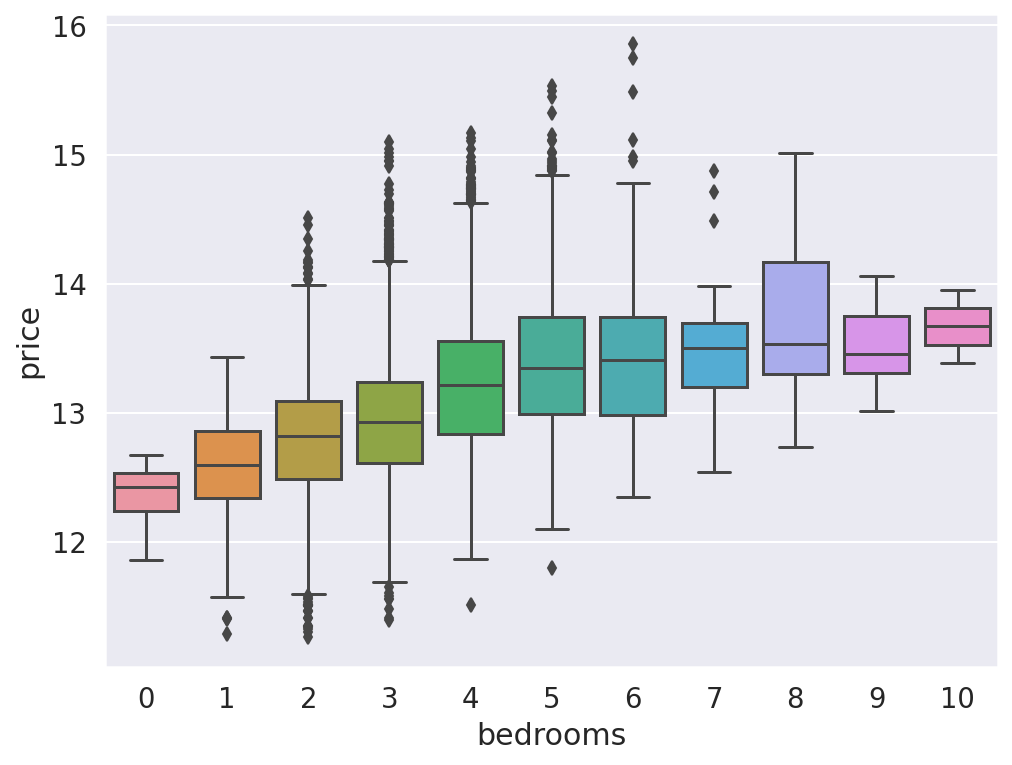

In [34]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

침실의 수는 median이 양의 상관관계를 띄고 있습니다. <br>
그리고 bedrooms가 2 ~ 6은 분산이 매우 큰 것 확인 가능. <br>
가운데의 저 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지 말자

## 정규화

In [35]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

#### 변수 수정

- id 변수는 상관관계도 낮고 예측에 필요 없으므로 삭제 (삭제 전 train_id 저장해서 일단 남겨놓기)
- 날짜 데이터 길이 수정
- yr_renovated에서 0으로 채워진 값 nan으로 바꾼 뒤 
- nan에 yr_build(집 지어진 년도) 변수값으로 채우기

In [36]:
#df_train_id = df_train['id']
#df_train.drop(['id'],axis=1,inplace=True)
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8]).astype(int)
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

### 변수 생성
- (방의 전체 갯수)total_rooms = bedrooms + bathrooms
- (거실의 비율)sqft_ratio = sqft_living / sqft_lot
- (지하실 포함 전체 평방 피트)sqft_total_size = sqft_above + sqft_basement
- (면적 대비 거실의 비율)sqft_ratio_1 = sqft_living / sqft_total_size
- (15년 기준 거실의 비율)sqft_ratio15 = sqft_living15 / sqft_lot15
- (재건축 여부) is_renovated

In [37]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [38]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    # 지하실 포함 전체 평방 피트
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    # 2015년 기준 거실의 비율
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

#### 집값은 비슷한 지역에 영향을 받기 때문에 zipcode 변수 사용해보기
단순 집값이 아닌 평당 가격 써야한다!!

In [39]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15030 entries, 0 to 15029
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15030 non-null  int64  
 1   date             15030 non-null  int64  
 2   price            15030 non-null  float64
 3   bedrooms         15030 non-null  int64  
 4   bathrooms        15030 non-null  float64
 5   sqft_living      15030 non-null  float64
 6   sqft_lot         15030 non-null  float64
 7   floors           15030 non-null  float64
 8   waterfront       15030 non-null  int64  
 9   view             15030 non-null  int64  
 10  condition        15030 non-null  int64  
 11  grade            15030 non-null  int64  
 12  sqft_above       15030 non-null  float64
 13  sqft_basement    15030 non-null  float64
 14  yr_built         15030 non-null  int64  
 15  yr_renovated     15030 non-null  float64
 16  zipcode          15030 non-null  int64  
 17  lat         

#### => 모두 실수 or 정수 자료형으로 모델 학습 활용 가능!!

## 3. 모델링

### 3.1 단순 선형회귀

In [41]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,5650,4.00,0.818803,7.074117,1.0,0.237168,0,1.740145,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,8062,3.00,0.721756,6.647688,1.0,0.337385,0,1.820290,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,7503,5.00,0.825489,7.427144,1.0,0.239904,0,1.769478,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,6819,5.25,0.843688,7.447751,1.0,0.328201,0,1.672824,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,9711,4.50,0.758837,6.966967,1.0,0.169910,0,1.806238,10.032009,1.002206


In [42]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.745e+06
Date:                Sun, 23 Jan 2022   Prob (F-statistic):                        0.00
Time:                        14:16:31   Log-Likelihood:                         -10.264
No. Observations:               15030   AIC:                                      70.53
Df Residuals:                   15005   BIC:                                      261.0
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

#### p-value 높은 값 확인 가능 -> 다중공선성 체크해보자!

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
23,sqft_total_size,inf
21,total_rooms,inf
3,bedrooms,inf
4,bathrooms,inf
13,sqft_basement,inf
12,sqft_above,inf
16,zipcode,5.293985e+06
1,date,4.284150e+06
18,long,2.054571e+06
17,lat,2.440404e+05


**VIF 10 이상**이면 다중공선성 존재.<br>
**is_renovated, sqft_lot15, view, waterfront** 제외한 모든 변수에 다중공선성 존재.<br>

해결방안은?
- 다중공선성에 robust한 트리모델을 사용하는 방법
- 변수제거 및 FE, 변환등을 통한 대체
- 관측값을 늘려 표본의 크기를 증가

### 3.2 LightGBM

In [44]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
     #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139382	valid_1's rmse: 0.162968
[1000]	training's rmse: 0.120777	valid_1's rmse: 0.158956
[1500]	training's rmse: 0.108175	valid_1's rmse: 0.158277
Early stopping, best iteration is:
[1502]	training's rmse: 0.108117	valid_1's rmse: 0.15827
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.139022	valid_1's rmse: 0.161039
[1000]	training's rmse: 0.120456	valid_1's rmse: 0.157606
[1500]	training's rmse: 0.10803	valid_1's rmse: 0.156625
[2000]	training's rmse: 0.0979526	valid_1's rmse: 0.156296
Early stopping, best iteration is:
[2133]	training's rmse: 0.0956746	valid_1's rmse: 0.156219
[LightGBM] [Warning] min_data_in_leaf is s

In [45]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

113204.71216353853


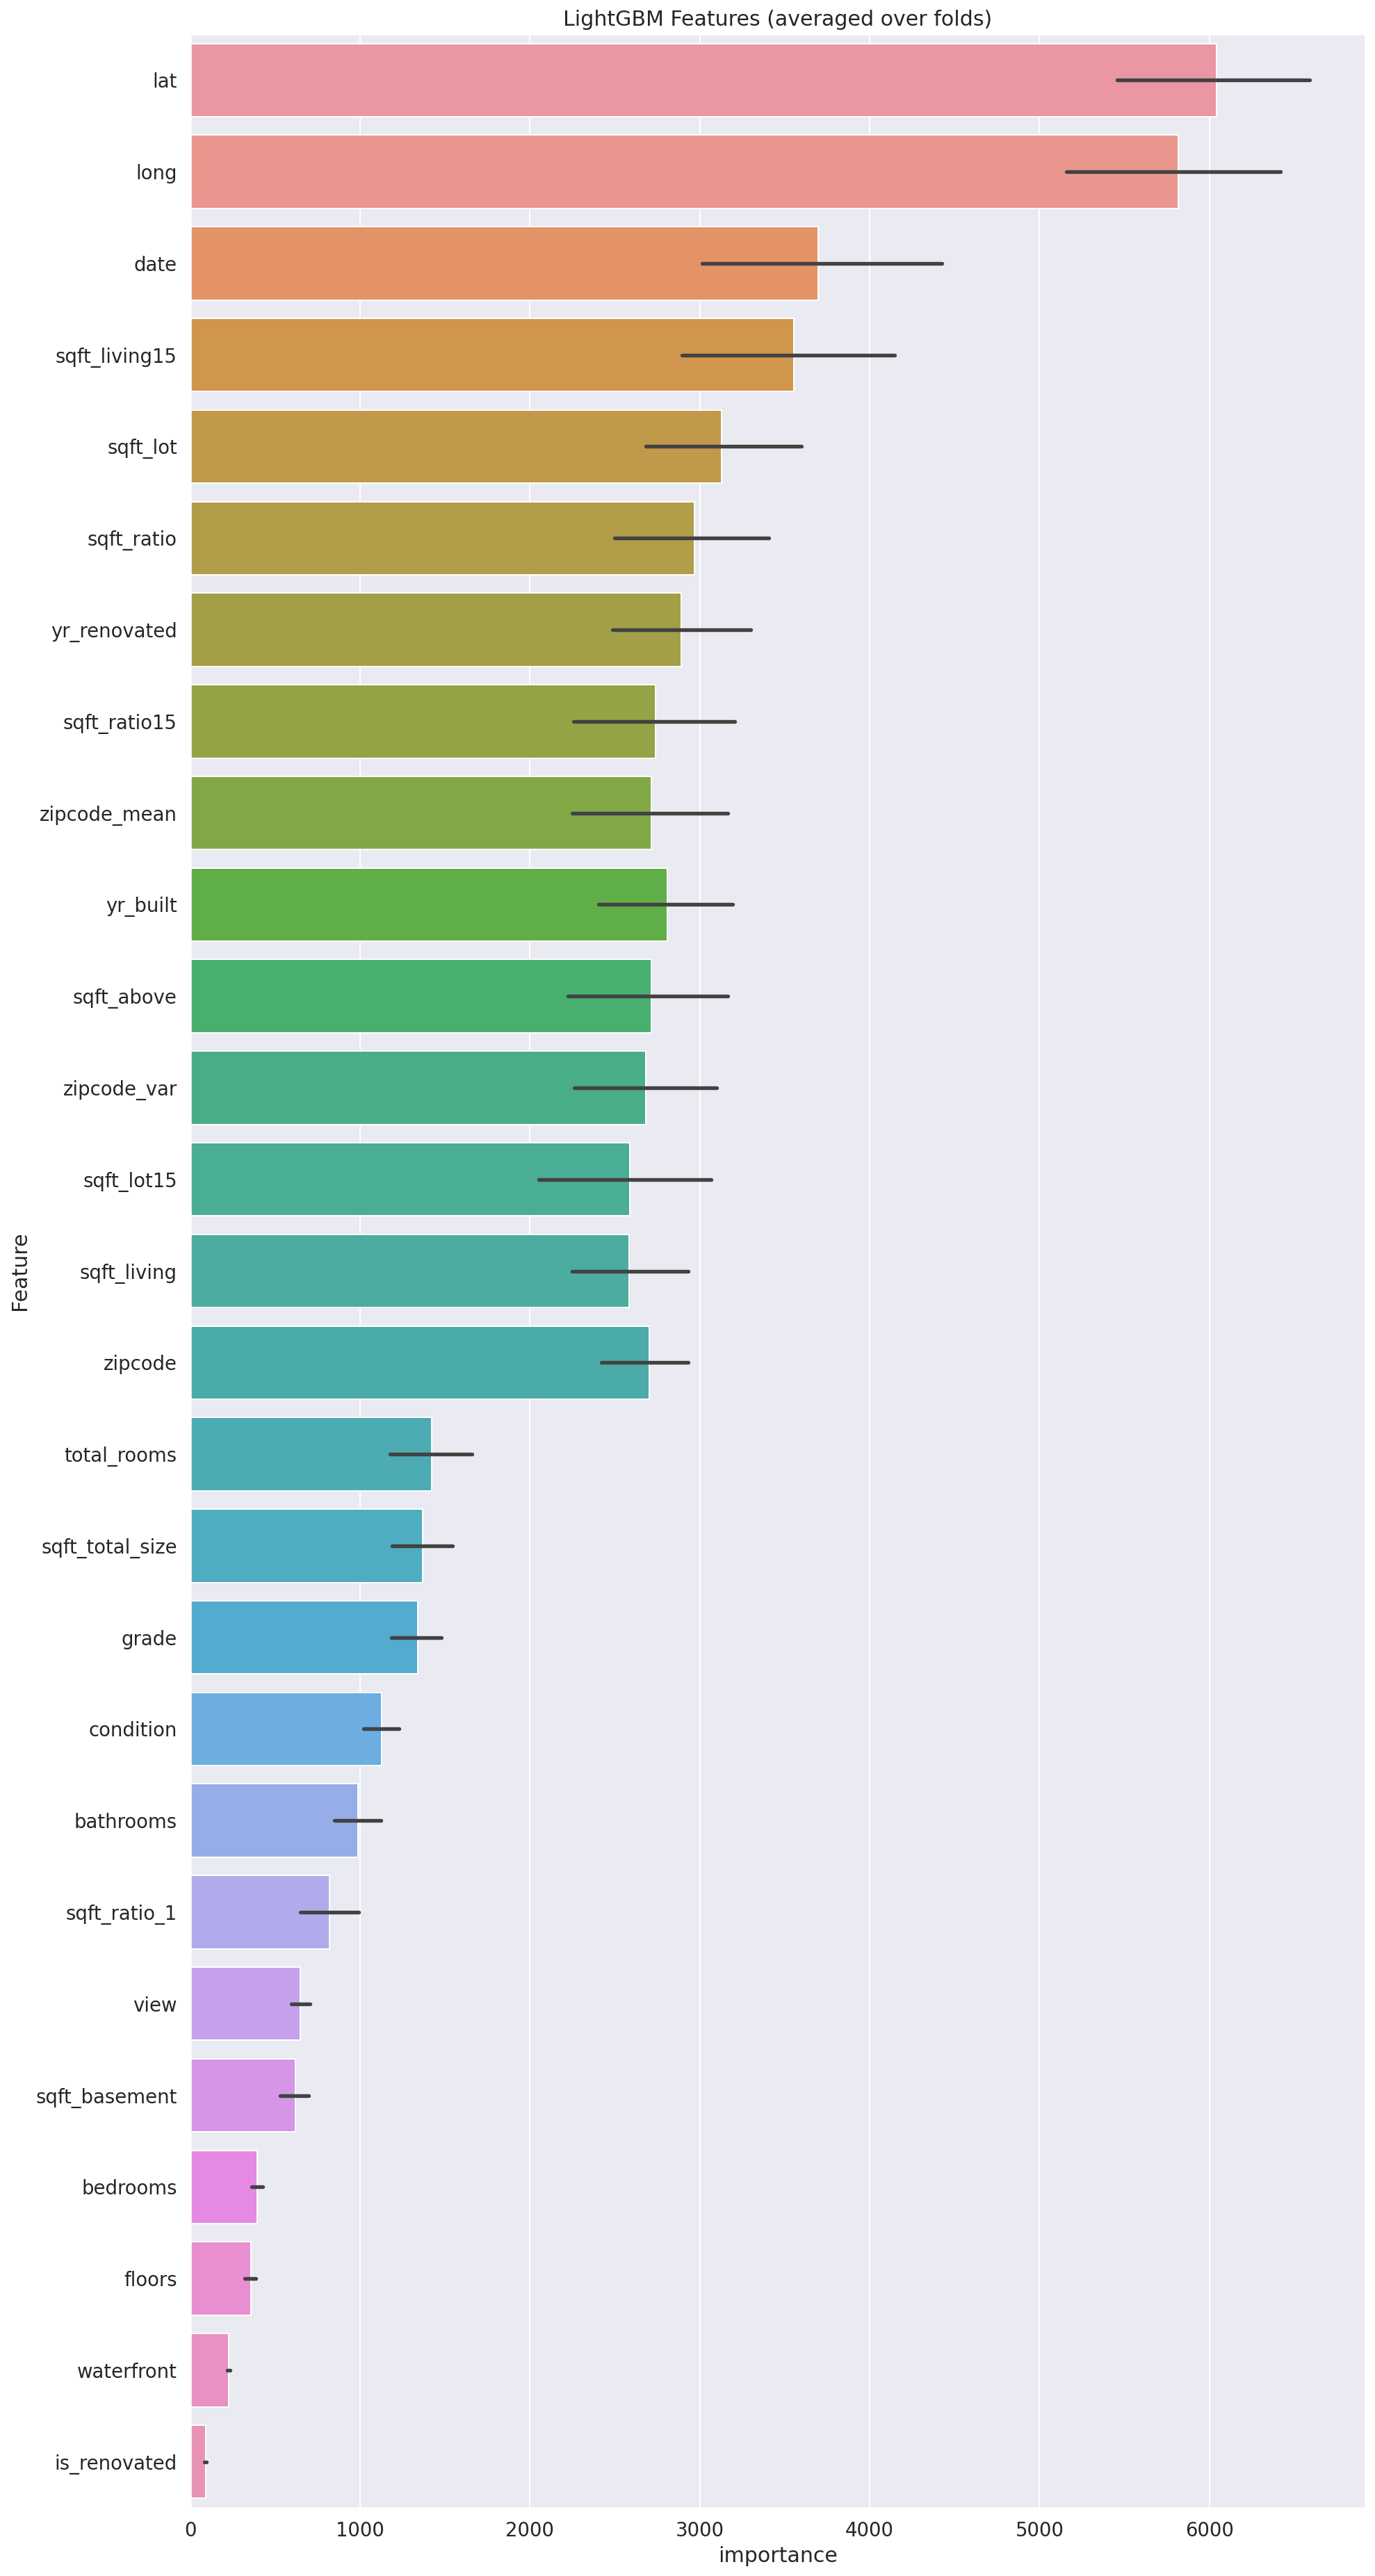

In [46]:
# feature 중요도 그래프
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

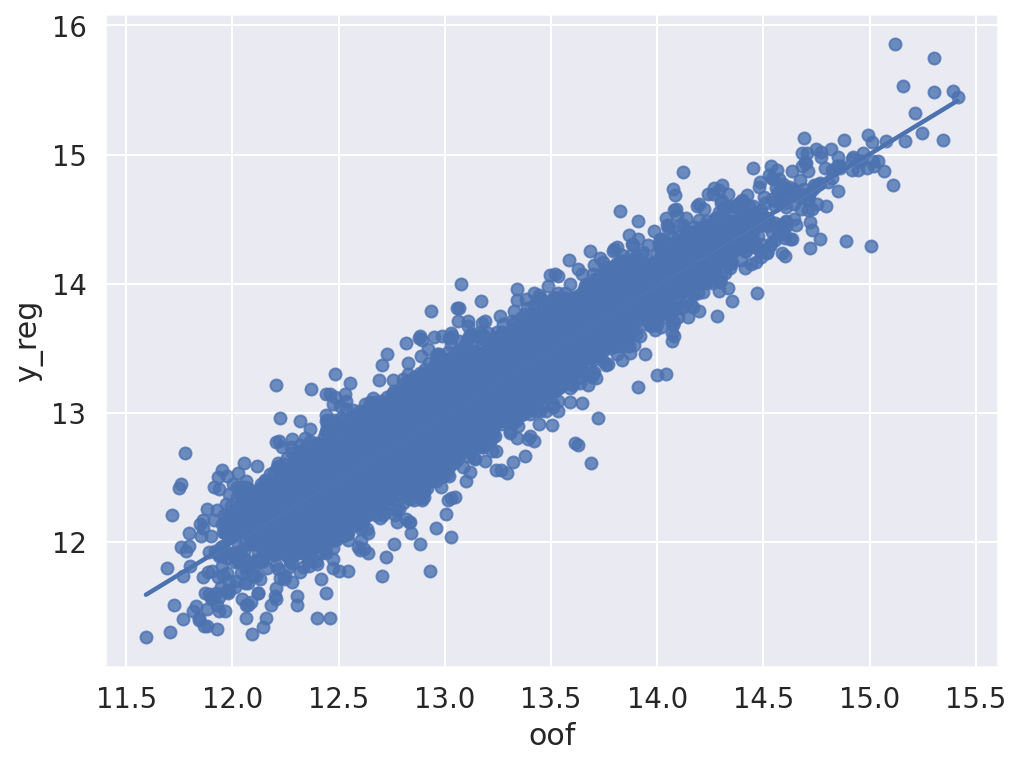

In [47]:
# oof 예측값
# y_reg 정답값
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='oof', y="y_reg", data=data)

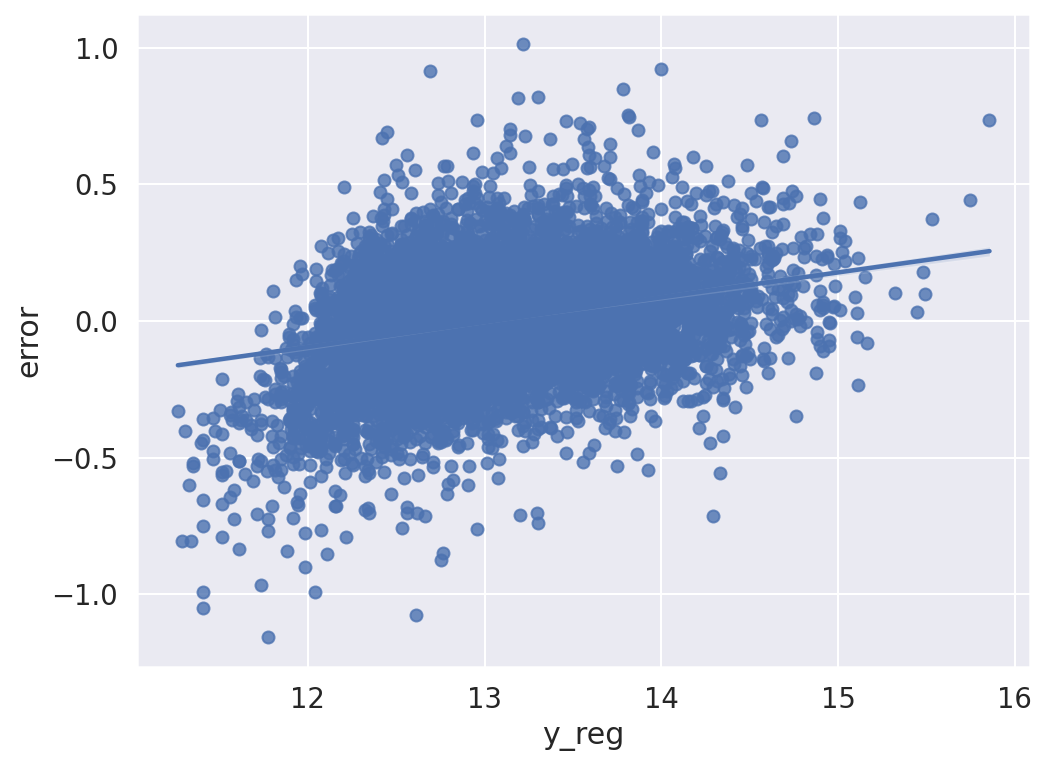

In [48]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='y_reg', y="error", data=data)

실제 y_reg와 error와의 관계를 보면 잔차가 독립적이지 않다. <br>
13~14부근은 error가 0에 가깝지만 15 이상은 더 높게 예측을 하는 경향을 보이고, 12이하는 더 낮게 예측하는 경향을 보인다.

이를 개선하기 위해서는

- 15이상에서 크게 예측한 이유
- 12이하에서 작게 예측하는 이유
- error가 0.5 이상인 값들의 이유 <br>

3가지 관점에서 접근을 해야 한다.

### Ensemble

In [49]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

113204.71216353853


In [50]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 129573	valid_1's rmse: 145714
[1000]	training's rmse: 105094	valid_1's rmse: 127123
[1500]	training's rmse: 95555.9	valid_1's rmse: 122286
[2000]	training's rmse: 88815.4	valid_1's rmse: 119956
[2500]	training's rmse: 83388.2	valid_1's rmse: 118749
[3000]	training's rmse: 78970.4	valid_1's rmse: 117961
[3500]	training's rmse: 75143.4	valid_1's rmse: 117473
[4000]	training's rmse: 71843.4	valid_1's rmse: 117162
[4500]	training's rmse: 68863.6	valid_1's rmse: 116904
Early stopping, best iteration is:
[4489]	training's rmse: 68926.7	valid_1's rmse: 116902
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 129900	valid_1's rmse: 1400

In [51]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

121159.3529337798


In [52]:
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
best num_boost_rounds =  3103


In [53]:
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[14:21:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an is

In [54]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

112866.14290109905


In [55]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [56]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [57]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]
ensemble_sub.to_csv("submission.csv",index=False)